## 1. Load Data

In [1]:
!pip install openpyxl
!pip install squarify

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import squarify
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_excel('/content/online_retail_II.xlsx', engine='openpyxl')

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 2. Data Discovery

In [5]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316




1.   The min price is a negative number, which could be an error.

  The max price is 25111.09, which indicates outliers exist as the 75% quartile is only 4.21.
2.   Customer ID is a float type, which can be converted to integer for data integrity.
3. Change Customer ID naming convention to accomdate other column names for naming consistency.



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


1. Convert Customer ID from float to int.
2. Columns Description and Customer ID have null values.

## 3. Data Cleaning

In [7]:
# check duplicates
# get the number of duplicates
df.duplicated().sum()

6865

In [8]:
# display duplicates
# duplicates are those that occur for a second or more times. The first occurance does not display.
df[df.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
...,...,...,...,...,...,...,...,...
523258,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065.0,United Kingdom
523356,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041.0,United Kingdom
525170,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907.0,United Kingdom
525293,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.0,United Kingdom


In [9]:
# remove duplicates
df_no_duplicates = df.drop_duplicates()
print(f"number of rows after removing duplicates: {len(df_no_duplicates)}")
print(f"number of rows before removing duplicates: {len(df)}")

number of rows after removing duplicates: 518596
number of rows before removing duplicates: 525461


In [10]:
# check missing values
df_no_duplicates.isnull().sum()

,0
Invoice,0
StockCode,0
Description,2928
Quantity,0
InvoiceDate,0
Price,0
Customer ID,107833
Country,0


In [11]:
# count unique values for Column Description
df['Description'].nunique()

4681

In [12]:
df['Customer ID'].nunique()

4383

In [13]:
# Change Customer ID column name for consistency
df_no_duplicates.rename(columns={'Customer ID': 'CustomerID'}, inplace = True)

In [14]:
# convert CustomerID float type to int for data integrity
# if NaN exists, we have to deal with it first.
df_no_duplicates['CustomerID'] = df_no_duplicates['CustomerID'].fillna(-1).astype(int)

In [15]:
# fill null values in the 'Description' column baed on 'Stockcode'
df_no_duplicates['Description'] = df_no_duplicates.groupby('StockCode')['Description'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)

In [16]:
df_no_duplicates.isnull().sum()

,0
Invoice,0
StockCode,0
Description,365
Quantity,0
InvoiceDate,0
Price,0
CustomerID,0
Country,0


In [17]:
# further fill null values in the 'Description' column with 'No Description'
df_no_duplicates['Description'] = df_no_duplicates['Description'].fillna('No Description')

In [18]:
df_no_duplicates['Description'].dtype

dtype('O')

1. For null values in CustomerID, we set it to '-1', so we can then convert its type which cannot handle null values.
2. For Description, we fill it by maping its StockCode to the description, and 'No Description' for remaining null values.

In [19]:
df_no_duplicates.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [20]:
# count # of rows when Quantity < 0
len(df_no_duplicates[df_no_duplicates['Quantity'] < 0])

12302

In [21]:
# filter out rows when quantity < 0
df_positive_quantity = df_no_duplicates[df_no_duplicates['Quantity'] >= 0]
df_positive_quantity.shape

(506294, 8)

In [22]:
len(df_positive_quantity[df_positive_quantity['Price'] < 0])

3

In [23]:
# filter rows when Price < 0
df_positive_price = df_positive_quantity[df_positive_quantity['Price'] >= 0]
df_positive_price.shape

(506291, 8)

## 4. Data Manipulation

In [24]:
# get month
df_positive_price['Month'] = df_positive_price['InvoiceDate'].dt.month
df_positive_price.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12


In [25]:
df_positive_price['MonthText'] = df_positive_price['InvoiceDate'].dt.month_name().str.slice(stop=3)
df_positive_price.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,MonthText
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,Dec
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,Dec
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,Dec


In [26]:
# get week
df_positive_price['Week'] = df_positive_price['InvoiceDate'].dt.isocalendar().week

In [27]:
# get day of each date
df_positive_price['Day'] = df_positive_price['InvoiceDate'].dt.day

In [28]:
df_positive_price.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,MonthText,Week,Day
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,Dec,49,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,Dec,49,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,Dec,49,1


# 5. EDA

## 5.1 Outliers and Anomalies

In [29]:
df_positive_price.describe()

,Quantity,InvoiceDate,Price,CustomerID,Month,Week,Day
count,506291.000000,506291,506291.000000,506291.000000,506291.000000,506291.0,506291.000000
mean,11.836272,2010-06-28 16:26:30.485116672,4.261520,12164.987742,7.445929,30.227721,15.258081
min,1.000000,2009-12-01 07:45:00,0.000000,-1.000000,1.000000,1.0,1.000000
25%,1.000000,2010-03-21 13:38:00,1.250000,12748.000000,4.000000,17.0,8.000000
50%,3.000000,2010-07-06 14:05:00,2.100000,14606.000000,8.000000,33.0,15.000000
75%,12.000000,2010-10-15 13:21:00,4.210000,16450.000000,11.000000,44.0,23.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000,12.000000,52.0,31.000000
std,93.592003,NaN,63.994952,6412.891514,3.541833,15.347564,8.697007


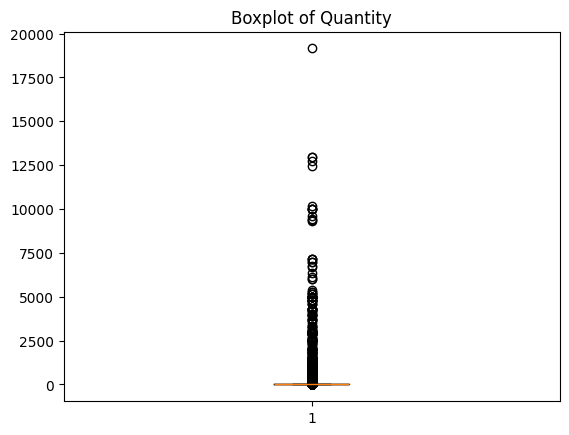

In [30]:
plt.boxplot(df_positive_price['Quantity'])
plt.title('Boxplot of Quantity')
plt.show()

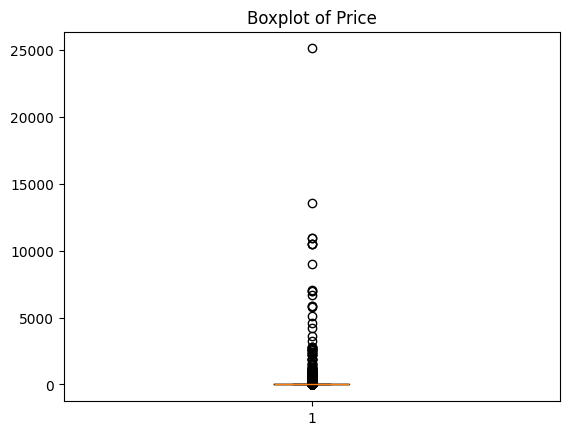

In [31]:
plt.boxplot(df_positive_price['Price'])
plt.title('Boxplot of Price')
plt.show()

## 5.2 Sales Trend by Time

In [32]:
df_positive_price['Sales'] = df_positive_price['Quantity'] * df_positive_price['Price']

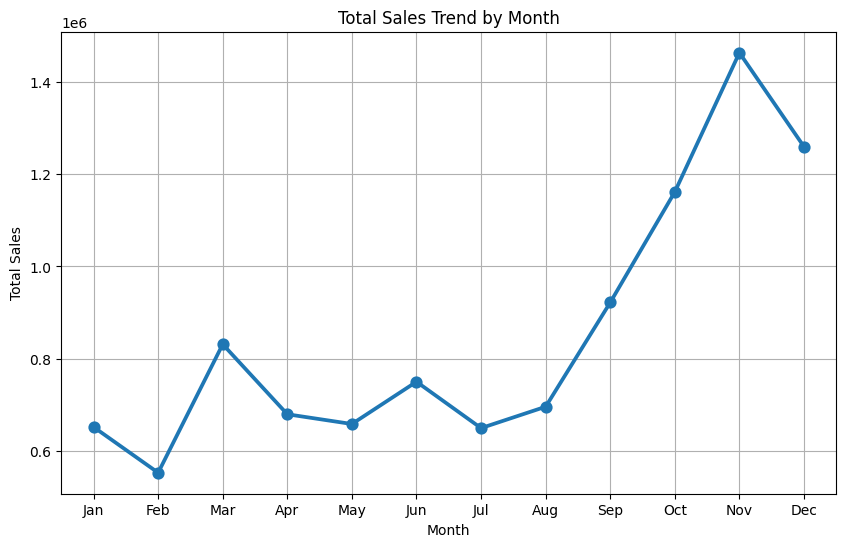

In [33]:
# Sales trend by month

months = df_positive_price.groupby('Month')['Sales'].sum().index
sales = df_positive_price.groupby(['Month'])['Sales'].sum().values

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(10, 6))
sns.pointplot(x=months, y=sales) # Use seaborn's pointplot
plt.title('Total Sales Trend by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

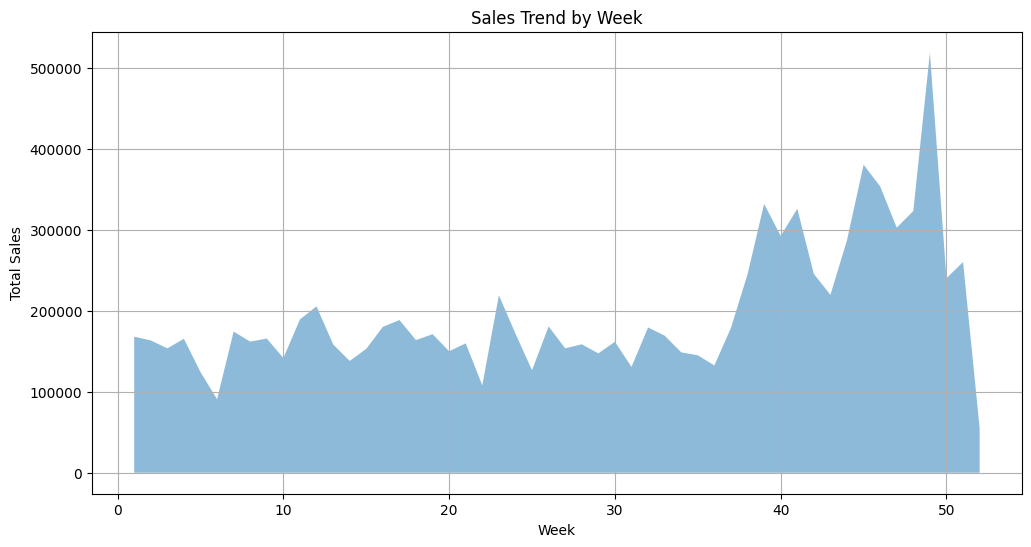

In [34]:
# plot sales trend by week

weeks = df_positive_price.groupby('Week')['Sales'].sum().index
sales_by_week = df_positive_price.groupby(['Week'])['Sales'].sum().values

plt.figure(figsize=(12, 6))
plt.fill_between(weeks, sales_by_week, alpha=0.5)  # Use fill_between for area plot
plt.title('Sales Trend by Week')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

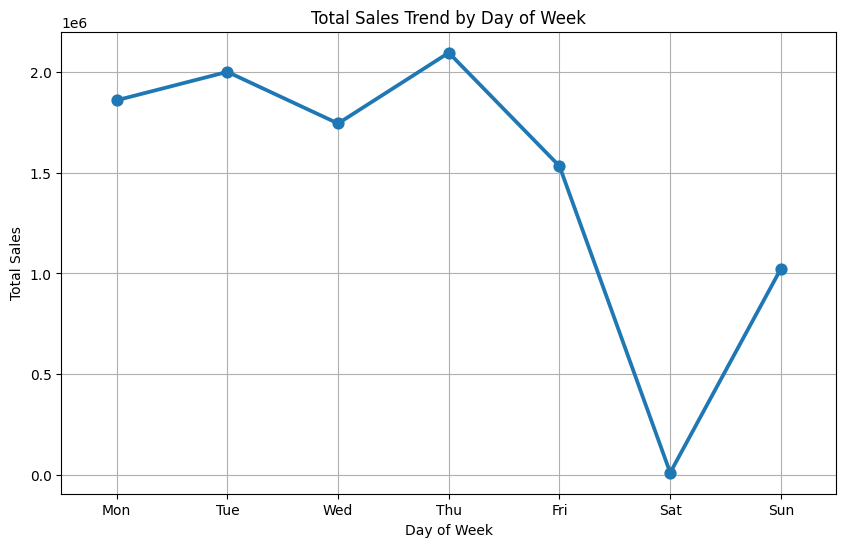

In [35]:
# plot sales trend by day of week
df_positive_price['DayOfWeek'] = df_positive_price['InvoiceDate'].dt.dayofweek
day_of_week_sales = df_positive_price.groupby('DayOfWeek')['Sales'].sum()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10, 6))
sns.pointplot(x=days, y=day_of_week_sales.values) # Use seaborn's pointplot
plt.title('Total Sales Trend by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

1. The largest sales come from September to December, peaking at November.
2. The week that has the larget sales is 49, close to the Christmas holiday.
3. Customer buy the least during the weekend, almost none on Saturday.

## 5.3 Sales by Product

In [36]:
df_positive_price.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,MonthText,Week,Day,Sales,DayOfWeek
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,Dec,49,1,83.4,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1,81.0,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1,81.0,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,Dec,49,1,100.8,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,Dec,49,1,30.0,1


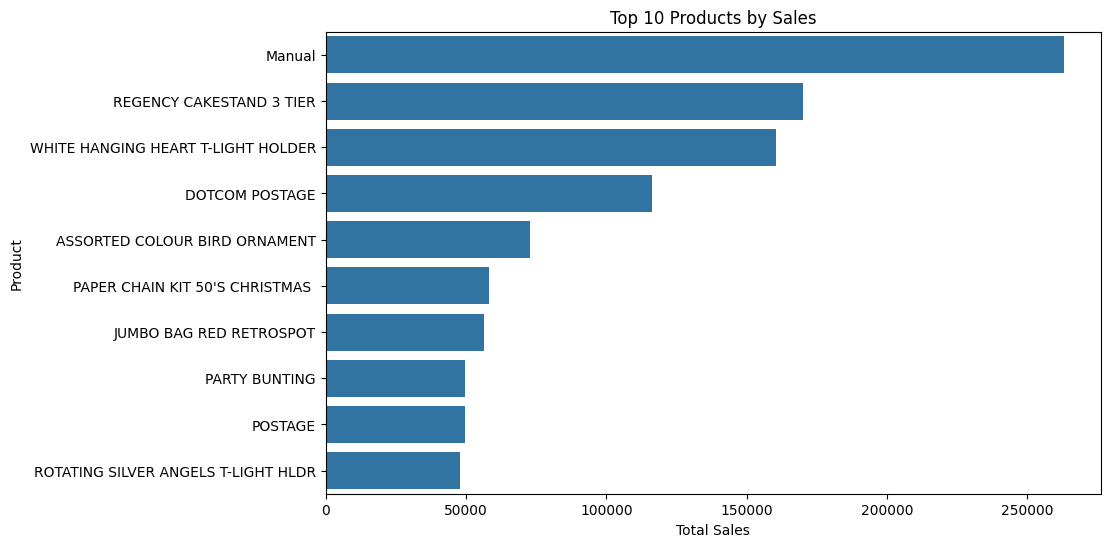

In [37]:
# top 10 products by sales
plt.figure(figsize=(10, 6))
product_sales = df_positive_price.groupby('Description')['Sales'].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(y='Description', x='Sales', data=product_sales, orient='h')
plt.title('Top 10 Products by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product')
plt.show()

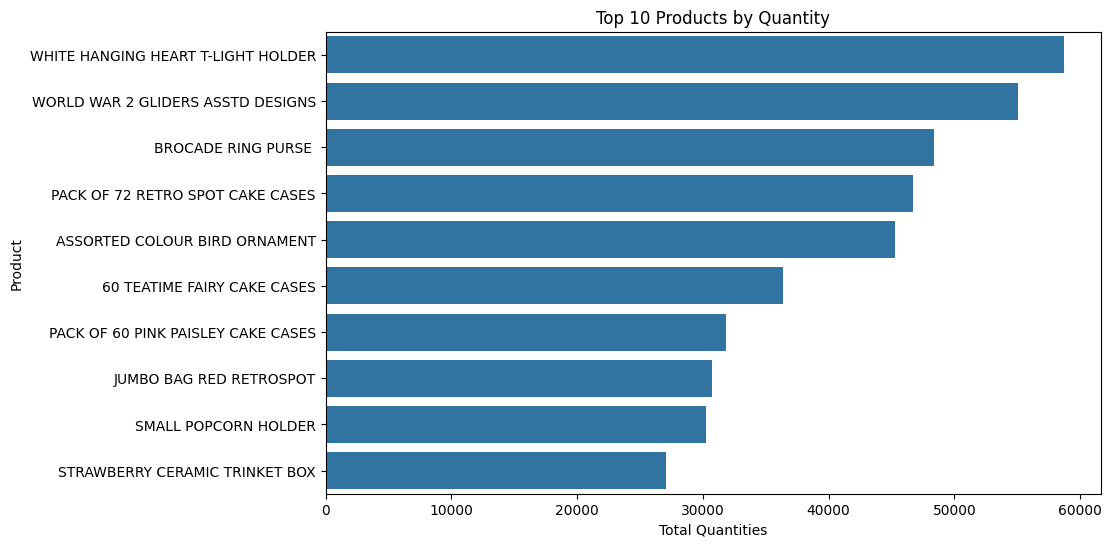

In [38]:
# top 10 products by quantities
plt.figure(figsize=(10, 6))
product_quantities = df_positive_price.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()
sns.barplot(y='Description', x='Quantity', data=product_quantities, orient='h')
plt.title('Top 10 Products by Quantity')
plt.xlabel('Total Quantities')
plt.ylabel('Product')
plt.show()

In [39]:
# overlapping products
product_sales_quantity = pd.merge(product_sales, product_quantities, on='Description', suffixes=('_sales', '_quantity'))
product_sales_quantity

,Description,Sales,Quantity
0,WHITE HANGING HEART T-LIGHT HOLDER,160345.63,58692
1,ASSORTED COLOUR BIRD ORNAMENT,72890.19,45236
2,JUMBO BAG RED RETROSPOT,56480.46,30748


In [40]:
# percentage of 10 top products accounting for the total sales
total_sales = df_positive_price['Sales'].sum()
top_10_sales = product_sales['Sales'].sum()
percentage_top_10_sales = (top_10_sales / total_sales) * 100
percentage_top_10_sales

10.1656033975065

1. We find out the top 10 products by sales and quantity are different, and 3 products are among the top 10 by both sales and quantity.
2. The top 10 products by sales accounts for 10.46% of the total sales.

## 5.4 Sales by Country

In [41]:
sales_by_country = df_positive_price.groupby('Country')['Sales'].sum().sort_values(ascending=False).reset_index()
# sales_by_country

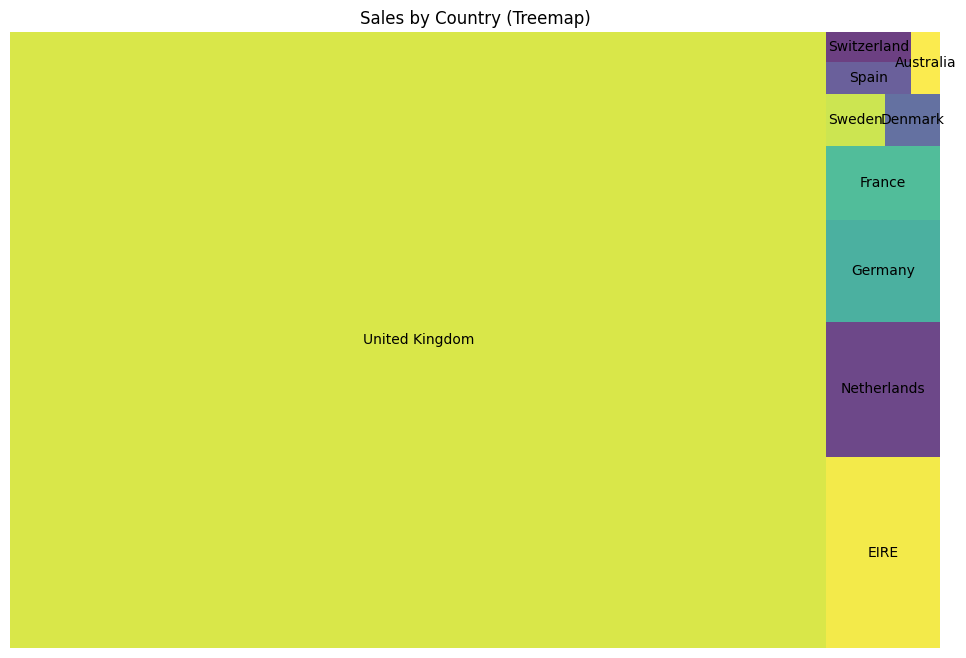

In [42]:
# top 10 countries by sales
plt.figure(figsize=(12,8))
squarify.plot(sizes=sales_by_country['Sales'].head(10), label=sales_by_country['Country'].head(10), alpha=0.8)
plt.title('Sales by Country (Treemap)')
plt.axis('off')
plt.show()

In [43]:
# top 10 products for top 5 countries
top_5_countries = sales_by_country.head(5)['Country'].tolist()

# top products by sale in each of those 5 countries
top_products_by_country = df_positive_price[df_positive_price['Country'].isin(top_5_countries)].groupby(['Country', 'Description'])['Sales'].sum().reset_index().groupby('Country').apply(lambda x: x.sort_values('Sales', ascending = False).head(5)).reset_index(drop = True)
top_products_by_country

<ipython-input-43-c05f7effebe9>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_by_country = df_positive_price[df_positive_price['Country'].isin(top_5_countries)].groupby(['Country', 'Description'])['Sales'].sum().reset_index().groupby('Country').apply(lambda x: x.sort_values('Sales', ascending = False).head(5)).reset_index(drop = True)


,Country,Description,Sales
0,EIRE,Manual,16810.12
1,EIRE,REGENCY CAKESTAND 3 TIER,8083.20
2,EIRE,SET/5 RED SPOTTY LID GLASS BOWLS,4935.90
3,EIRE,CARRIAGE,4765.00
4,EIRE,PLEASE ONE PERSON METAL SIGN,3270.00
5,France,POSTAGE,9558.00
6,France,Manual,5020.70
7,France,RED TOADSTOOL LED NIGHT LIGHT,2435.40
8,France,ROUND SNACK BOXES SET OF4 WOODLAND,1823.05
9,France,S/4 BLUE ROUND DECOUPAGE BOXES,1653.12


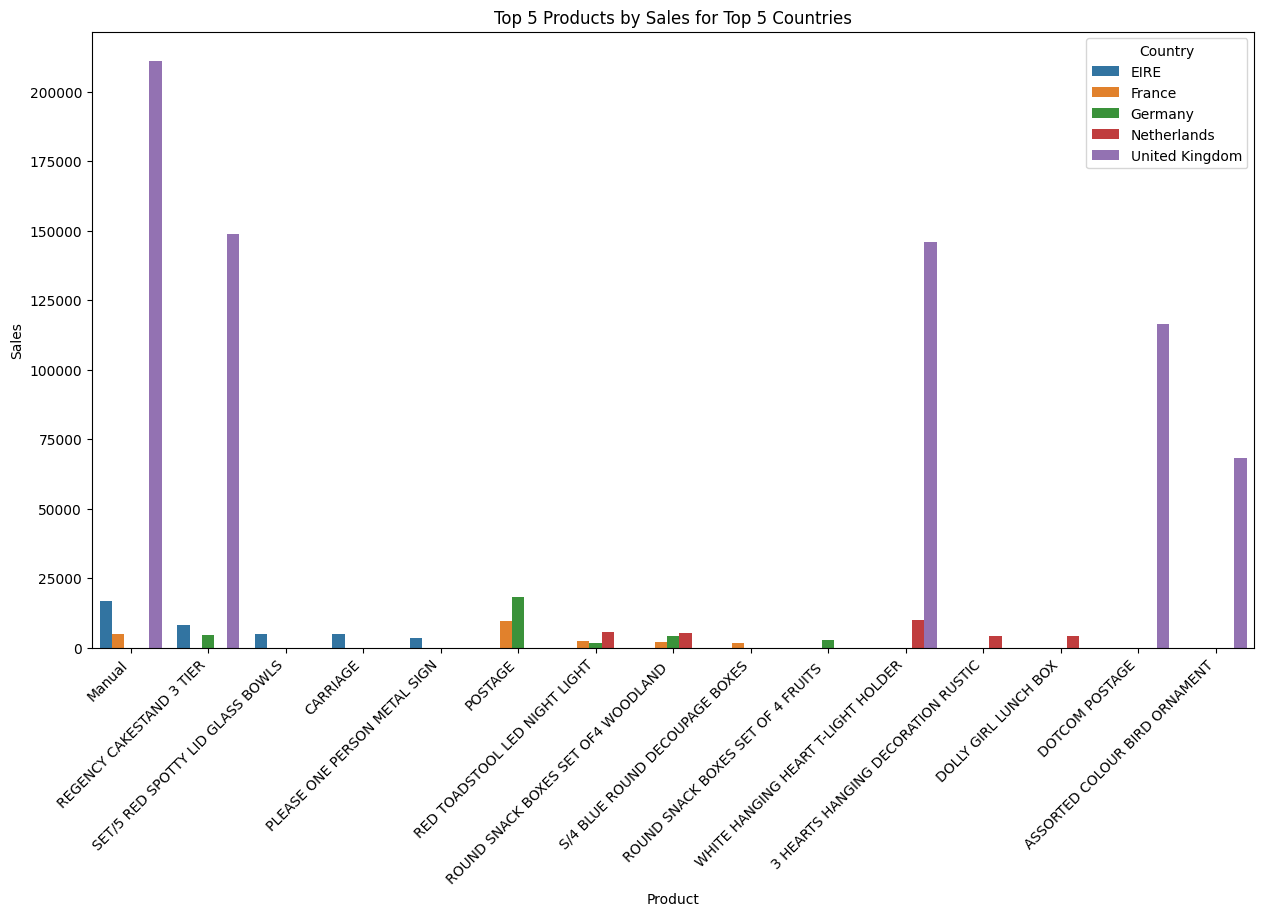

In [44]:

plt.figure(figsize=(15, 8))
sns.barplot(x='Description', y='Sales', hue='Country', data=top_products_by_country)
plt.title('Top 5 Products by Sales for Top 5 Countries')
plt.xlabel('Product')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

In [45]:
# orders by country
orders_by_country = df_positive_price['Country'].value_counts()
orders_by_country

,count
Country,
United Kingdom,468153
EIRE,9451
Germany,7652
France,5514
Netherlands,2729
Spain,1228
Switzerland,1170
Portugal,1058
Belgium,1037


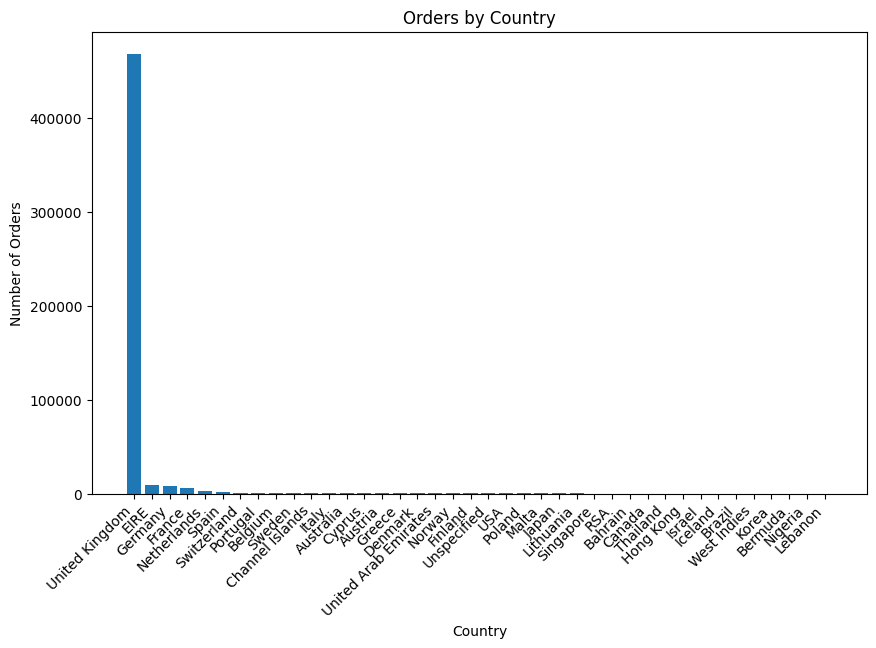

In [46]:
plt.figure(figsize=(10, 6))
plt.bar(orders_by_country.index, orders_by_country.values)
plt.title('Orders by Country')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.show()

1. UK accounts for the largest portion of sales, following by EIRE, Netherland, Germany and France.
2. Every country has different top products by sales, indicating personalized marketing.
3. Orders positively correlate with sales.

## 5.5 Customers Behavior

In [47]:
# the top 10 customers by sales
top_10_customers = df_positive_price.groupby('CustomerID')['Sales'].sum().sort_values(ascending=False).head(11).reset_index()
top_10_customers[top_10_customers['CustomerID'] != -1]

,CustomerID,Sales
1,18102,349164.35
2,14646,248396.50
3,14156,196549.74
4,14911,152121.22
5,13694,131443.19
6,17511,84541.17
7,15061,83284.38
8,16684,80489.21
9,16754,65500.07
10,17949,60117.60


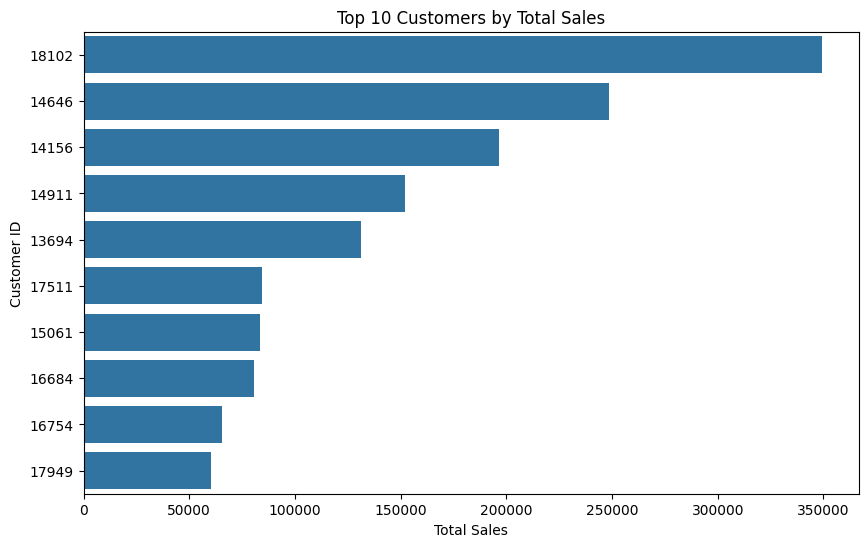

In [48]:
# Plotting the top 10 customers by sales
top_10_customers['CustomerID'] = top_10_customers['CustomerID'].astype('str')
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales', y='CustomerID', data=top_10_customers[top_10_customers['CustomerID'] != '-1'].sort_values('Sales', ascending=False).reset_index(), orient='h')
plt.title('Top 10 Customers by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Customer ID')
plt.show()



In [49]:
# create year-month for customer consumption trending analysis
df_positive_price['YearMonth'] = df_positive_price['InvoiceDate'].dt.to_period('M')
df_positive_price.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,MonthText,Week,Day,Sales,DayOfWeek,YearMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,12,Dec,49,1,83.4,1,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1,81.0,1,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,12,Dec,49,1,81.0,1,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,12,Dec,49,1,100.8,1,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,12,Dec,49,1,30.0,1,2009-12


In [50]:
df_positive_price_top_10_customers = df_positive_price[df_positive_price['CustomerID'].isin(top_10_customers['CustomerID'].astype('int'))]
df_positive_price_top_10_customers

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,MonthText,Week,Day,Sales,DayOfWeek,YearMonth
54,489438,21329,DINOSAURS WRITING SET,28,2009-12-01 09:24:00,0.98,18102,United Kingdom,12,Dec,49,1,27.44,1,2009-12
55,489438,21252,SET OF MEADOW FLOWER STICKERS,30,2009-12-01 09:24:00,1.69,18102,United Kingdom,12,Dec,49,1,50.70,1,2009-12
56,489438,21100,CHARLIE AND LOLA CHARLOTTE BAG,30,2009-12-01 09:24:00,1.15,18102,United Kingdom,12,Dec,49,1,34.50,1,2009-12
57,489438,21033,JUMBO BAG CHARLIE AND LOLA TOYS,30,2009-12-01 09:24:00,2.00,18102,United Kingdom,12,Dec,49,1,60.00,1,2009-12
58,489438,20711,JUMBO BAG TOYS,60,2009-12-01 09:24:00,1.30,18102,United Kingdom,12,Dec,49,1,78.00,1,2009-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525144,538154,84029E,RED WOOLLY HOTTIE WHITE HEART.,5,2010-12-09 16:35:00,8.47,-1,United Kingdom,12,Dec,49,9,42.35,3,2010-12
525145,538154,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2010-12-09 16:35:00,8.47,-1,United Kingdom,12,Dec,49,9,33.88,3,2010-12
525146,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,-1,United Kingdom,12,Dec,49,9,4.21,3,2010-12
525147,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,-1,United Kingdom,12,Dec,49,9,85.79,3,2010-12


In [51]:
# customer sales over time
df_positive_price_top_10_customers = df_positive_price[df_positive_price['CustomerID'].astype('str').isin(top_10_customers['CustomerID'])]
customer_sales_over_time = df_positive_price_top_10_customers.groupby(['CustomerID', 'YearMonth'])['Sales'].sum().reset_index()
customer_sales_over_time

,CustomerID,YearMonth,Sales
0,-1,2009-12,138979.94
1,-1,2010-01,95352.44
2,-1,2010-02,47319.34
3,-1,2010-03,133936.79
4,-1,2010-04,86893.25
...,...,...,...
127,18102,2010-07,52609.31
128,18102,2010-08,46516.39
129,18102,2010-10,30195.56
130,18102,2010-11,22092.51


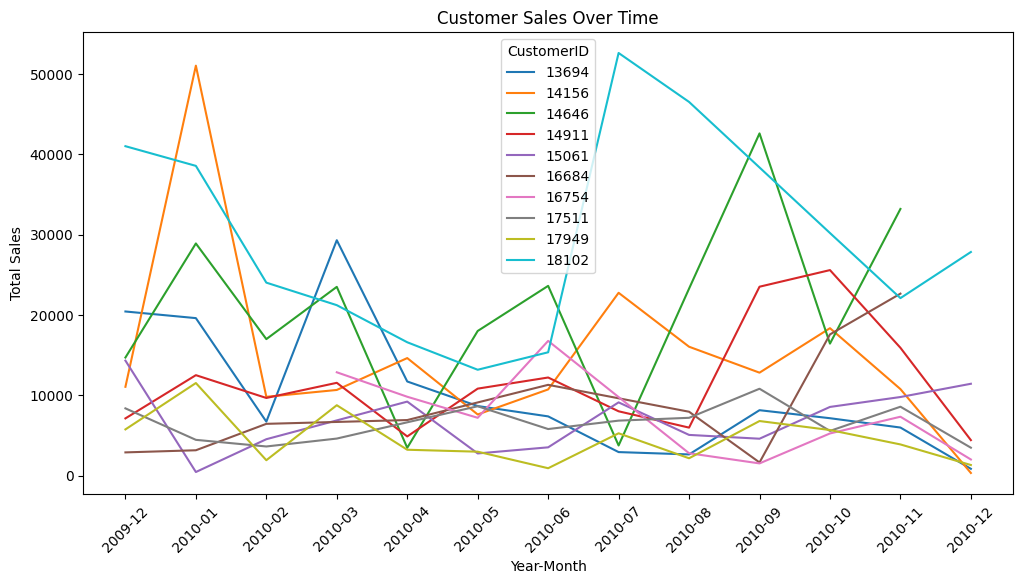

In [52]:
# plot top 10 customers purchase trend
customer_sales_over_time['YearMonth'] = customer_sales_over_time['YearMonth'].astype(str)
customer_sales_over_time['CustomerID'] = customer_sales_over_time['CustomerID'].astype(str)  # sns treats hue as numerical values

plt.figure(figsize=(12,6))
sns.lineplot(x='YearMonth', y='Sales', hue='CustomerID', data=customer_sales_over_time[customer_sales_over_time['CustomerID'] != '-1'])
plt.title('Customer Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


## 6. Customer Segmentation - RFM Model

In [53]:
# Calculate Recency
recent_date = df_positive_price['InvoiceDate'].max()
df_positive_price['Recency'] = (recent_date - df_positive_price['InvoiceDate']).dt.days

# Calculate Frequency and MonetaryValue
customer_rfm = df_positive_price.groupby('CustomerID').agg({
  'InvoiceDate': lambda x: (recent_date - x.max()).days,
  'Invoice': 'nunique',
  'Sales': 'sum'
})
customer_rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
customer_rfm = customer_rfm[customer_rfm.index != -1]

In [54]:
# Assign RFM scores (1-4) based on quantiles
quantiles = customer_rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
customer_rfm['R'] = customer_rfm['Recency'].apply(RScore, args=('Recency', quantiles))
customer_rfm['F'] = customer_rfm['Frequency'].apply(FMScore, args=('Frequency', quantiles))
customer_rfm['M'] = customer_rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue', quantiles))

customer_rfm['RFMGroup'] = customer_rfm.R.map(str) + customer_rfm.F.map(str) + customer_rfm.M.map(str)
customer_rfm['RFMScore'] = customer_rfm[['R', 'F', 'M']].sum(axis=1)

In [55]:
# Create segments based on quantiles and RFM score combinations
customer_rfm['Segment'] = 'General'  # Default segment
customer_rfm.loc[customer_rfm['RFMScore'] >= 9, 'Segment'] = 'Champions'
customer_rfm.loc[(customer_rfm['RFMScore'] >= 6) & (customer_rfm['RFMScore'] < 9), 'Segment'] = 'Loyal Customers'
customer_rfm.loc[(customer_rfm['RFMScore'] >= 4) & (customer_rfm['RFMScore'] < 6), 'Segment'] = 'Potential Loyalists'


In [56]:
customer_rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFMGroup,RFMScore,Segment
CustomerID,,,,,,,,,
12346,164,11,372.86,1,4,2,142,7,Loyal Customers
12347,2,2,1323.32,4,2,3,423,9,Champions
12348,73,1,222.16,2,1,1,211,4,Potential Loyalists
12349,42,3,2671.14,3,3,4,334,10,Champions
12351,10,1,300.93,4,1,1,411,6,Loyal Customers
...,...,...,...,...,...,...,...,...,...
18283,17,6,619.37,4,4,2,442,10,Champions
18284,66,1,461.68,2,1,2,212,5,Potential Loyalists
18285,295,1,427.00,1,1,2,112,4,Potential Loyalists


In [57]:
customer_rfm['Segment'].value_counts()

,count
Segment,
Champions,1631
Loyal Customers,1345
Potential Loyalists,878
General,460


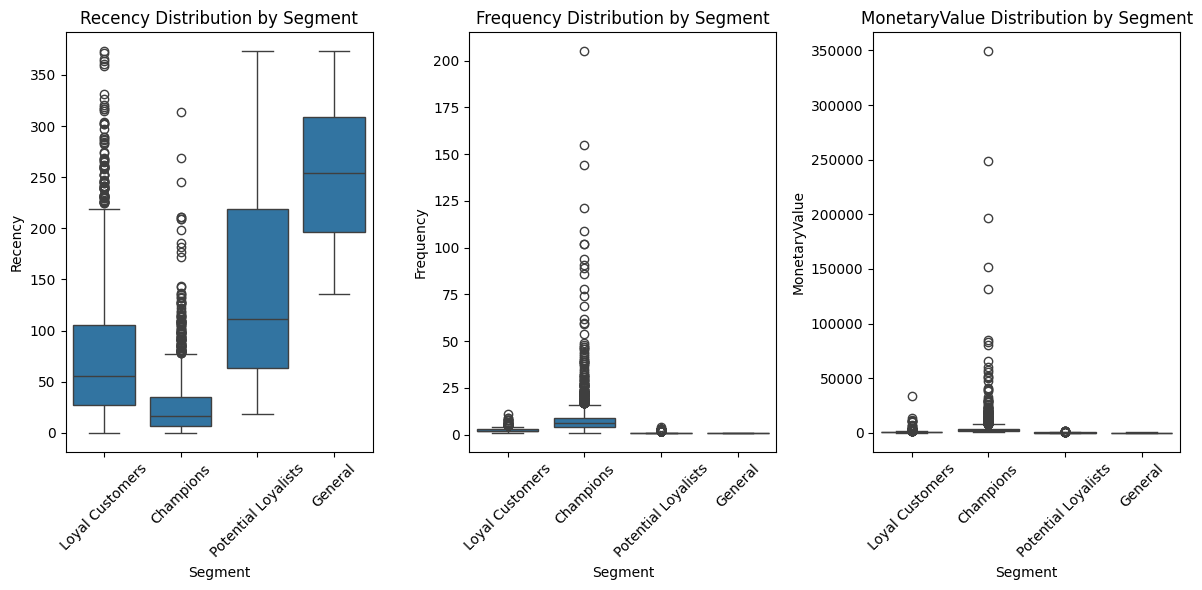

In [58]:
# Visualize the distribution of Recency, Frequency, and MonetaryValue across segments
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Segment', y='Recency', data=customer_rfm)
plt.title('Recency Distribution by Segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.boxplot(x='Segment', y='Frequency', data=customer_rfm)
plt.title('Frequency Distribution by Segment')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.boxplot(x='Segment', y='MonetaryValue', data=customer_rfm)
plt.title('MonetaryValue Distribution by Segment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

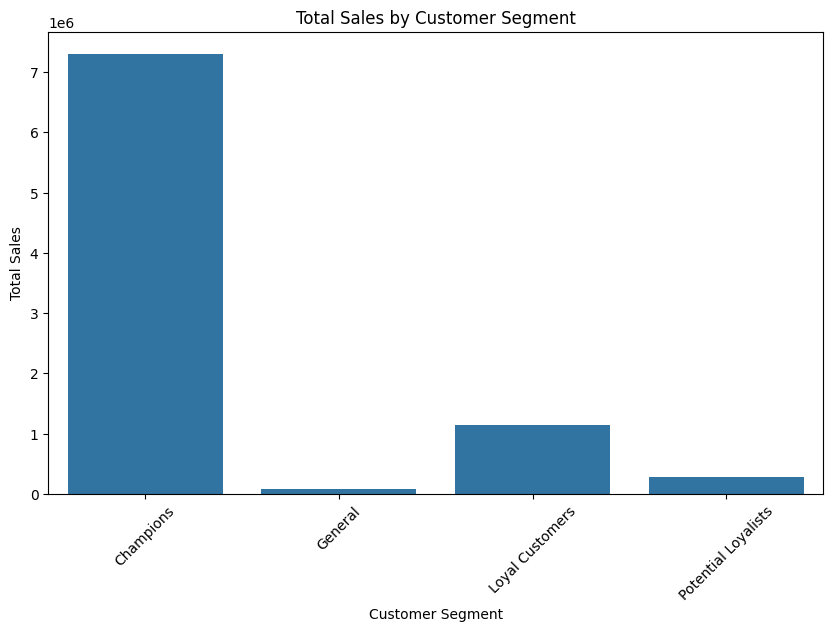

In [59]:

# Calculate sales by segment
segment_sales = customer_rfm.groupby('Segment')['MonetaryValue'].sum()

# Plotting sales by segment
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_sales.index, y=segment_sales.values)
plt.title('Total Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


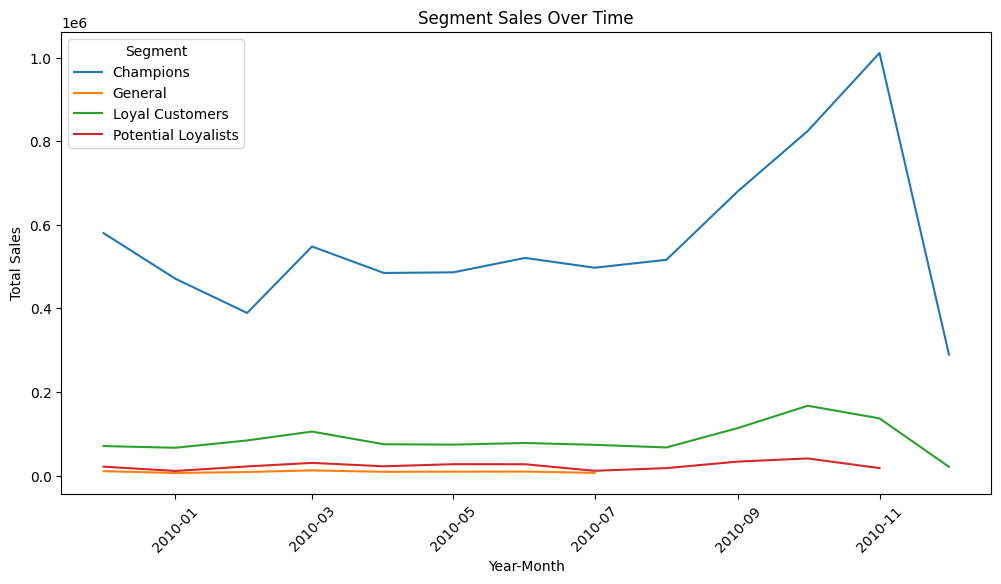

In [60]:
# Re-calculate sales by segment using the full dataset (df_positive_price)
segment_sales_over_time = df_positive_price.merge(customer_rfm, on='CustomerID', how='left').groupby(['Segment', 'YearMonth'])['Sales'].sum().reset_index()

# Convert 'YearMonth' to datetime objects for proper plotting
segment_sales_over_time['YearMonth'] = segment_sales_over_time['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='Sales', hue='Segment', data=segment_sales_over_time)
plt.title('Segment Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

1. The Champagne segment demonstrates the highest frequency of purchases, the shortest recency, and significantly the largest sales.
2. Throughout the entire year, all segments exhibit stable purchasing power, except for the General segment, which ceased in July 2010.

## 7. Customer Segmentation - Clustering

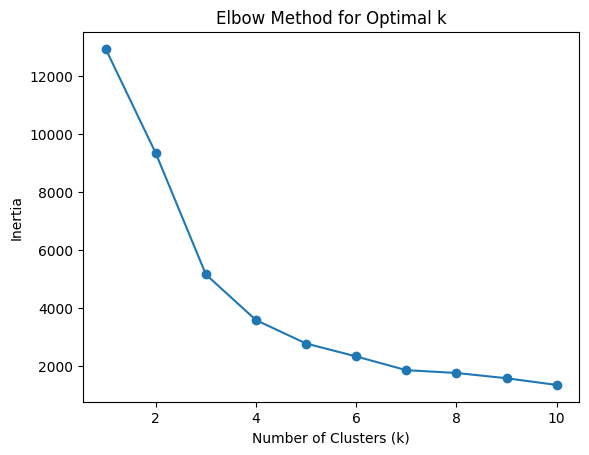

            Recency   Frequency  MonetaryValue
Cluster                                       
0         41.264279    4.942575    2073.316626
1        240.794727    1.653484     589.590522
2          3.230769  111.538462  112047.389231


In [61]:
# Select the RFM features for clustering
rfm_data = customer_rfm[['Recency', 'Frequency', 'MonetaryValue']]

scaler = StandardScaler()
scaled_rfm_data = scaler.fit_transform(rfm_data)

# Determine the optimal number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_rfm_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph to visually identify the optimal k
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow method, choose the optimal k value (e.g., k=3)
# Apply KMeans clustering with the chosen k
kmeans = KMeans(n_clusters=3, random_state=42)
customer_rfm['Cluster'] = kmeans.fit_predict(scaled_rfm_data)

# Analyze the characteristics of each cluster
cluster_means = customer_rfm.groupby('Cluster')[['Recency', 'Frequency', 'MonetaryValue']].mean()
print(cluster_means)


            Recency                    Frequency                  \
               mean median  min  max        mean median min  max   
Cluster                                                            
0         41.264279   31.0    0  211    4.942575    3.0   1   69   
1        240.794727  231.0  135  373    1.653484    1.0   1   11   
2          3.230769    2.0    0    9  111.538462  102.0  74  205   

         MonetaryValue                                    Segment  
                  mean     median       min        max   <lambda>  
Cluster                                                            
0          2073.316626    948.030     10.95   84541.17  Champions  
1           589.590522    304.675      0.00   34095.26    General  
2        112047.389231  60117.600  18482.10  349164.35  Champions  


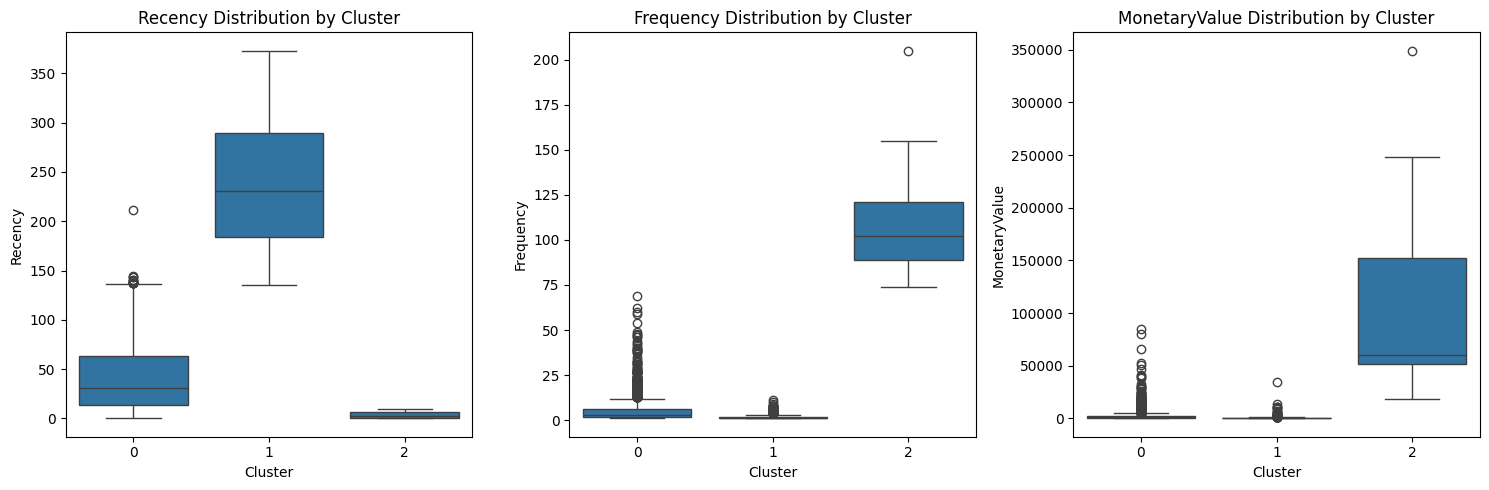

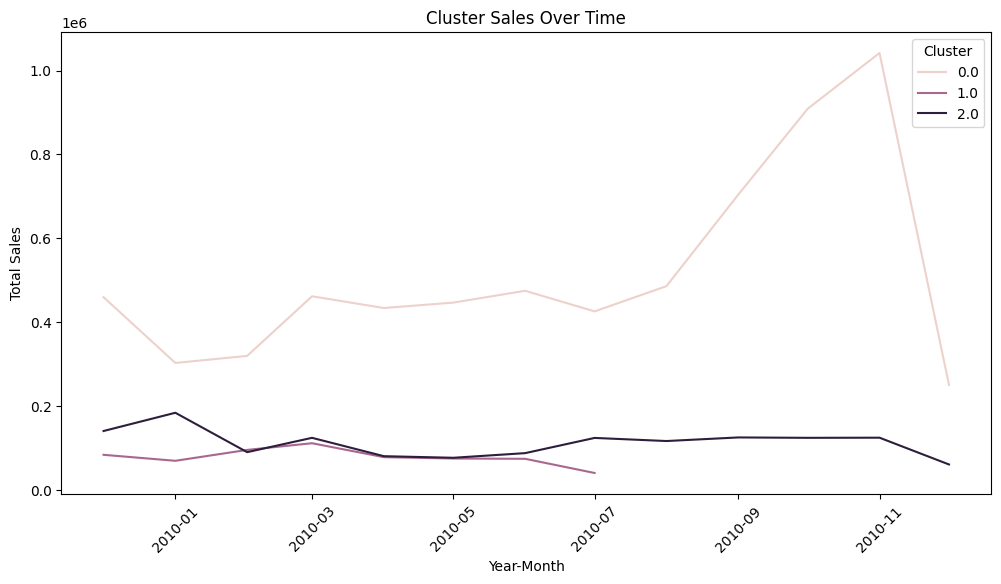

<ipython-input-62-b30d2f270913>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_products_by_cluster = df_positive_price.merge(customer_rfm, on='CustomerID').groupby(['Cluster', 'Description'])['Sales'].sum().reset_index().groupby('Cluster').apply(lambda x: x.sort_values('Sales', ascending=False).head(5)).reset_index(drop=True)


    Cluster                         Description      Sales
0         0  WHITE HANGING HEART T-LIGHT HOLDER  123948.79
1         0            REGENCY CAKESTAND 3 TIER   93294.00
2         0       ASSORTED COLOUR BIRD ORNAMENT   57486.51
3         0             JUMBO BAG RED RETROSPOT   47213.70
4         0                             POSTAGE   42322.60
5         1                              Manual   30434.23
6         1  WHITE HANGING HEART T-LIGHT HOLDER    8764.10
7         1     SMALL FAIRY CAKE FRIDGE MAGNETS    6467.60
8         1                             POSTAGE    5240.60
9         1             LUNCH BAG  BLACK SKULL.    4680.95
10        2            REGENCY CAKESTAND 3 TIER   47509.35
11        2                              Manual   27795.19
12        2  WHITE HANGING HEART T-LIGHT HOLDER   18626.27
13        2        VINTAGE UNION JACK MEMOBOARD   16533.09
14        2             CREAM HEART CARD HOLDER   14937.43


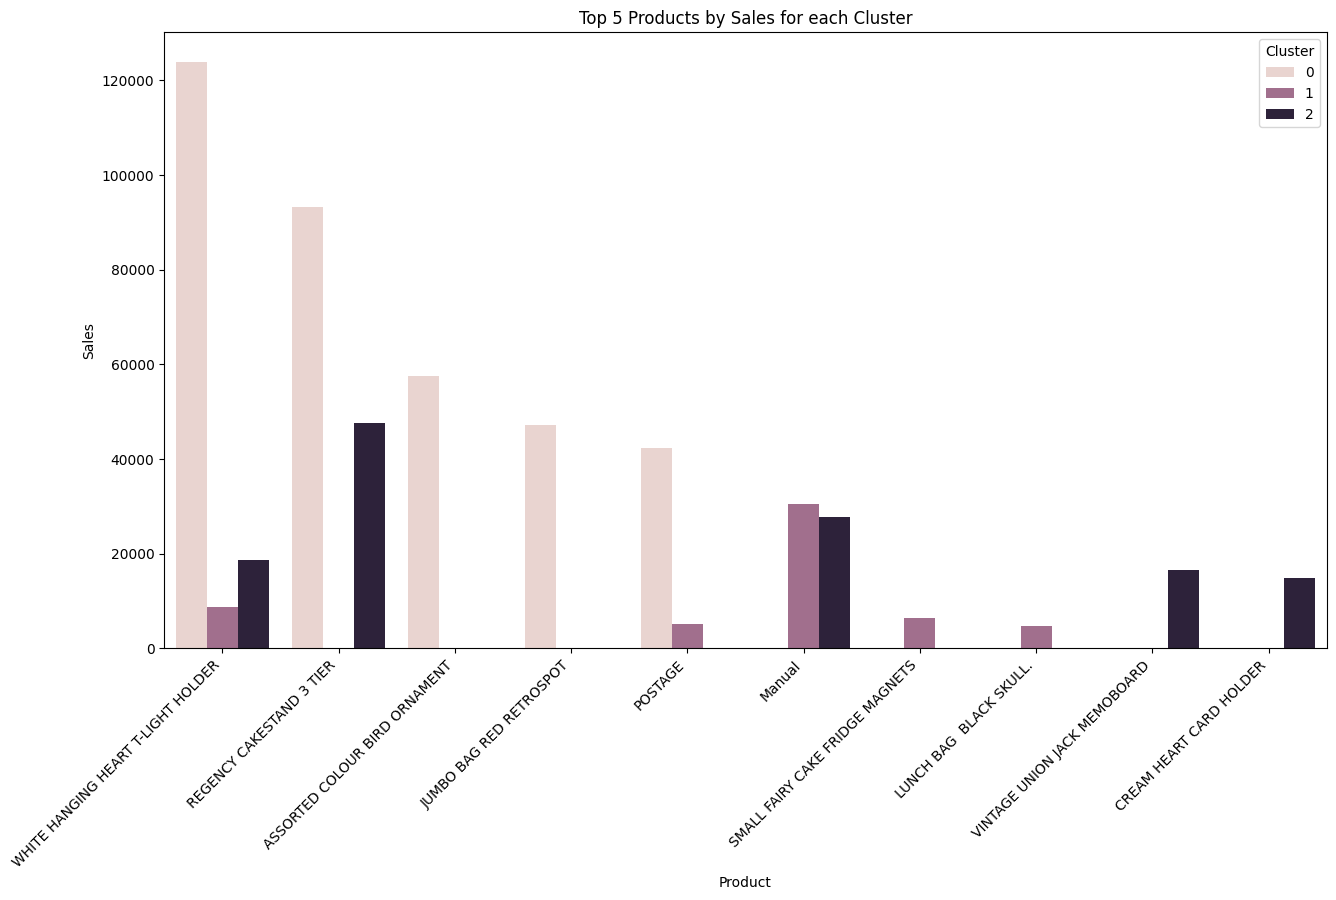

In [62]:
# Analyze the characteristics of each cluster in more detail.
cluster_analysis = customer_rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'MonetaryValue': ['mean', 'median', 'min', 'max'],
    'Segment': lambda x: x.value_counts().index[0]  # Most frequent segment in each cluster
})
print(cluster_analysis)

# Visualize cluster characteristics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=customer_rfm)
plt.title('Recency Distribution by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=customer_rfm)
plt.title('Frequency Distribution by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='MonetaryValue', data=customer_rfm)
plt.title('MonetaryValue Distribution by Cluster')

plt.tight_layout()
plt.show()

# Analyze sales trends within each cluster over time
cluster_sales_over_time = df_positive_price.merge(customer_rfm, on='CustomerID', how='left').groupby(['Cluster', 'YearMonth'])['Sales'].sum().reset_index()
cluster_sales_over_time['YearMonth'] = cluster_sales_over_time['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='Sales', hue='Cluster', data=cluster_sales_over_time)
plt.title('Cluster Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# Investigate the top products purchased by each cluster.
top_products_by_cluster = df_positive_price.merge(customer_rfm, on='CustomerID').groupby(['Cluster', 'Description'])['Sales'].sum().reset_index().groupby('Cluster').apply(lambda x: x.sort_values('Sales', ascending=False).head(5)).reset_index(drop=True)
print(top_products_by_cluster)

# Visualize top products per cluster
plt.figure(figsize=(15,8))
sns.barplot(x='Description', y='Sales', hue='Cluster', data = top_products_by_cluster)
plt.title('Top 5 Products by Sales for each Cluster')
plt.xlabel('Product')
plt.ylabel('Sales')
plt.xticks(rotation=45,ha='right')
plt.show()

## 8. CLTV Analysis

In [63]:
# Calculate average purchase value for each customer
customer_rfm['AvgPurchaseValue'] = customer_rfm['MonetaryValue'] / customer_rfm['Frequency']

In [64]:
# Calculate average purchase frequency for each customer
# We'll consider the period from the first invoice date to the last invoice date
# as the customer's active period
first_invoice_date = df_positive_price['InvoiceDate'].min()
last_invoice_date = df_positive_price['InvoiceDate'].max()
customer_rfm['AvgPurchaseFrequency'] = customer_rfm['Frequency'] / ((last_invoice_date - first_invoice_date).days / 365)  # Frequency per year

In [65]:
# We'll assume a simple customer lifespan of 3 years
customer_lifespan = 3

In [66]:
# Calculate CLTV for each customer
customer_rfm['CLTV'] = customer_rfm['AvgPurchaseValue'] * customer_rfm['AvgPurchaseFrequency'] * customer_lifespan

In [67]:
# Group by segment and calculate average CLTV
segment_cltv = customer_rfm.groupby('Segment')['CLTV'].mean()
print(segment_cltv)  # To see the output, run the code.

Segment
Champions              13142.441633
General                  473.052636
Loyal Customers         2480.279130
Potential Loyalists      956.370266
Name: CLTV, dtype: float64


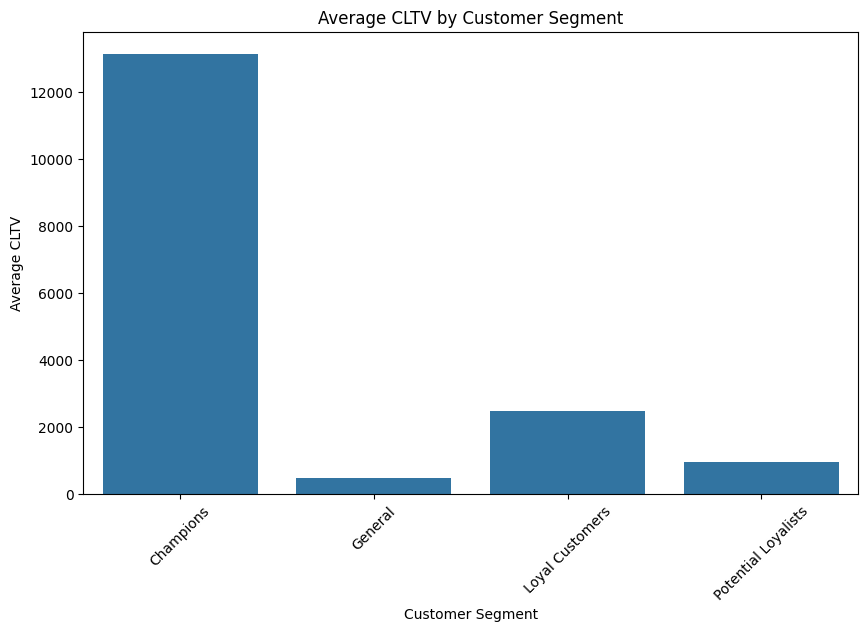

In [68]:
# Visualize CLTV by segment using a bar plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_cltv.index, y=segment_cltv.values)
plt.title('Average CLTV by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average CLTV')
plt.xticks(rotation=45)
plt.show()  # To see the output, run the code.

## 9. Cohort Analysis

In [69]:
# Create a 'CohortMonth' column representing the month of the customer's first purchase
df_positive_price['CohortMonth'] = df_positive_price.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [70]:
# Create a 'CohortIndex' column representing the number of months since the customer's first purchase
df_positive_price['CohortIndex'] = (df_positive_price['InvoiceDate'].dt.to_period('M') - df_positive_price['CohortMonth']).apply(lambda x: x.n)

In [71]:
# Create a cohort table showing the number of unique customers per cohort and index
cohort_table = df_positive_price.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_table = cohort_table.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [72]:
# Calculate retention rate
cohort_size = cohort_table.iloc[:, 0]  # Size of each cohort (customers in the first month)
retention_rate = cohort_table.divide(cohort_size, axis=0)

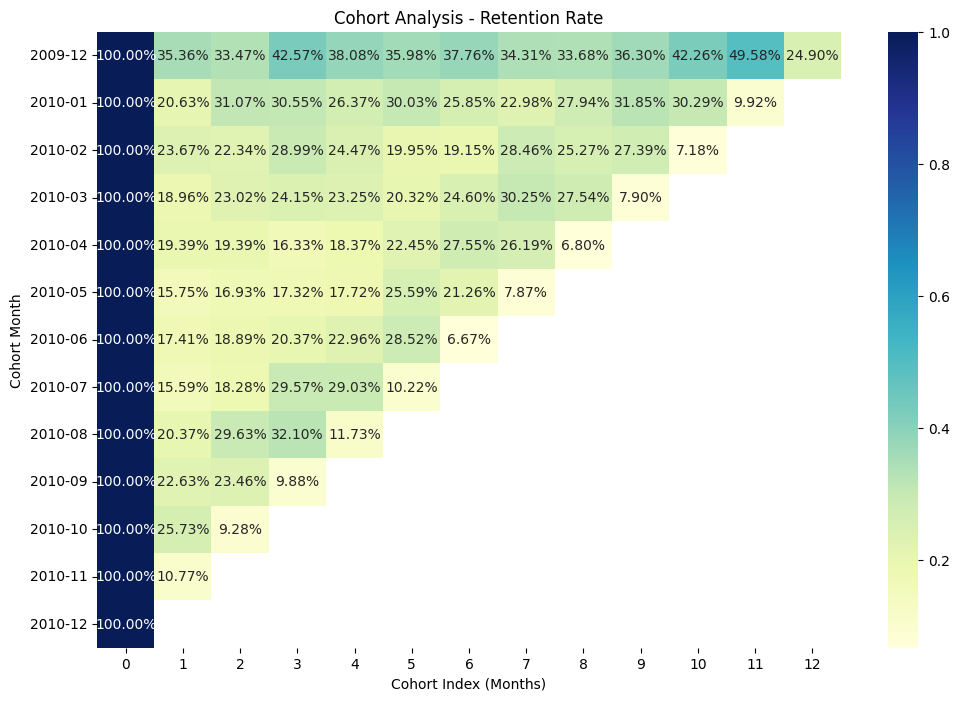

In [73]:
# Visualize retention rate using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(retention_rate, annot=True, fmt=".2%", cmap="YlGnBu")
plt.title('Cohort Analysis - Retention Rate')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cohort Month')
plt.show()